In [1]:
import gc
import os
import sys
import warnings
from glob import glob
import matplotlib.pyplot as plt

import albumentations as A
from albumentations.pytorch import ToTensorV2
import pandas as pd
import cv2
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import segmentation_models_pytorch as smp
from torch.cuda import amp
from tqdm import tqdm

In [2]:
sys.path.append('../')
from script.metrics import *
from script.dataset import *
from script.helper import *
from script.scheduler import *
from script.model import *
from script.loss import *

### Config

In [3]:
class CFG:
    debug = False
    # ============== comp exp name =============
    comp_name = 'contrail'
    comp_dir_path = '/kaggle/input/'
    comp_folder_name = 'google-research-identify-contrails-reduce-global-warming'

    dataset_path = "/kaggle/working/dataset_train/ash_color_4labels/"
    train_label_path = f"{dataset_path}/labels/true/"

    exp_name = os.getcwd().split('/')[-1]
    exp_description = "baseline-RandomRotate90"

    # ============== model cfg =============
    model_arch = 'Unet'
    backbone = 'timm-resnest50d'
    
    in_chans = 3
    target_size = 4

    # ============== training cfg =============
    train_batch_size = 32
    valid_batch_size = train_batch_size

    epochs = 40

    lr = 1e-4
    loss = "DiceLoss"
    smooth = 300
    
    # ============== fixed =============
    num_workers = 4
    seed = 42

    # ============== augmentation =============
    train_aug_list = [
        # A.RandomRotate90(),
        A.RandomBrightnessContrast(),
        A.ShiftScaleRotate(p=0.5,rotate_limit=(10,10)),
        A.GridDistortion(num_steps=5, distort_limit=0.3, p=0.5),
        A.CoarseDropout(max_holes=10, max_width=int(256 * 0.05), max_height=int(256 * 0.05),
                        mask_fill_value=0, p=0.5),
        A.RandomGridShuffle(),
        ToTensorV2(transpose_mask=True),
    ]

    valid_aug_list = [
        ToTensorV2(transpose_mask=True),
    ]


warnings.filterwarnings("ignore")
torch.backends.cudnn.benchmark = True
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
set_seed(CFG.seed)
os.makedirs(f'./{CFG.exp_name}/', exist_ok=True)
pd.options.display.max_colwidth = 300

# Dataset

In [4]:
train_df = pd.read_csv(f"{CFG.dataset_path}/train_df.csv")
valid_df = pd.read_csv(f"{CFG.dataset_path}/validation_df.csv")

if CFG.debug:
    train_df=train_df[:2000]
    valid_df=valid_df[:2000]
print(train_df.shape, valid_df.shape)
train_df.head()

(20529, 4) (1856, 4)


,record_id,image_path,label_path,time
0,1000216489776414077,/kaggle/working/dataset_train/ash_color_4labels/images/1000216489776414077_4.npy,/kaggle/working/dataset_train/ash_color_4labels/labels/true/1000216489776414077_4.npy,4
1,1000603527582775543,/kaggle/working/dataset_train/ash_color_4labels/images/1000603527582775543_4.npy,/kaggle/working/dataset_train/ash_color_4labels/labels/true/1000603527582775543_4.npy,4
2,1000660467359258186,/kaggle/working/dataset_train/ash_color_4labels/images/1000660467359258186_4.npy,/kaggle/working/dataset_train/ash_color_4labels/labels/true/1000660467359258186_4.npy,4
3,100071707854144929,/kaggle/working/dataset_train/ash_color_4labels/images/100071707854144929_4.npy,/kaggle/working/dataset_train/ash_color_4labels/labels/true/100071707854144929_4.npy,4
4,1000823728928031783,/kaggle/working/dataset_train/ash_color_4labels/images/1000823728928031783_4.npy,/kaggle/working/dataset_train/ash_color_4labels/labels/true/1000823728928031783_4.npy,4


In [5]:
class ContrailsDataset(Dataset):
    def __init__(self, df, transform, mode='train'):
        self.df = df
        self.transform = A.Compose(transform)
        self.mode = mode
        if "image_path" in df.columns:
            self.image_path_row = "image_path"
        if "path " in df.columns:
            self.image_path_row = "path"

    def __getitem__(self, index):
        row = self.df.iloc[index]
        record_id = row["record_id"]

        if self.mode == 'train':
            image_path = row[self.image_path_row]
            label_path = row["label_path"]
            image = np.load(str(image_path)).astype("float32")
            label = np.load(str(label_path)).astype("float32")
            data = self.transform(image=image, mask=label)
            image = data['image']
            label = data['mask']
            image = torch.tensor(image)
            return image.float(), label.float()

        if self.mode == 'valid':
            image_path = row[self.image_path_row]
            label_path = row["label_path"]
            image = np.load(str(image_path)).astype("float32")
            label = np.load(str(label_path)).astype("float32")
            data = self.transform(image=image, mask=label)
            image = data['image']
            label = data['mask']
            image = torch.tensor(image)
            return image.float(), label.float()

    def __len__(self):
        return len(self.df)


def show_dataset(idx, dataset):
    image, label = dataset[idx]
    label_num = label.shape[0]
    fig, axes = plt.subplots(nrows=1, ncols=1+label_num, figsize=(20, 4))
    axes = axes.flatten()
    fig.tight_layout(pad=0.1)
    axes[0].imshow(image.permute(1, 2, 0).to(torch.float))
    axes[0].axis('off')
    for i in range(label_num):
        axes[i+1].imshow(label[i].to(torch.float))
        axes[i+1].axis('off')


len(dataset_train) = 20529
train_image_shape : torch.Size([3, 256, 256])
train_mask_shape  : torch.Size([4, 256, 256])
train_image_dtype : torch.float32
train_mask_dtype : torch.float32

len(dataset_valid) = 1856
valid_image_shape : torch.Size([3, 256, 256])
valid_mask_shape  : torch.Size([1, 256, 256])
valid_image_dtype : torch.float32
valid_mask_dtype : torch.float32



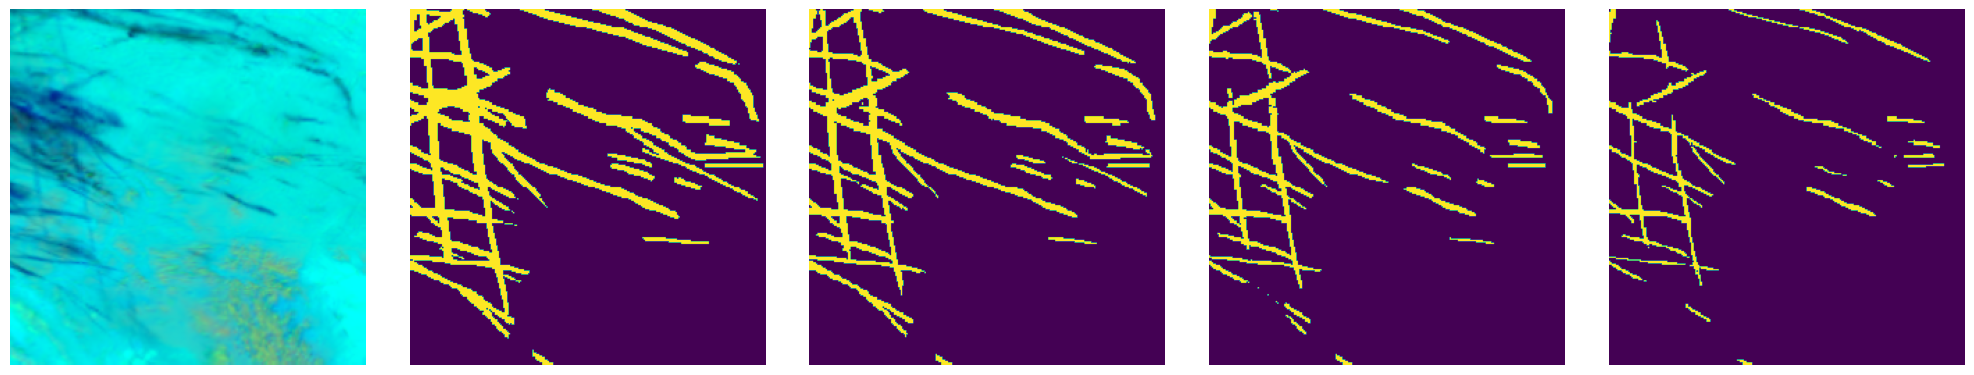

In [6]:
dataset_train = ContrailsDataset(train_df, CFG.train_aug_list, "train")
dataset_valid = ContrailsDataset(valid_df, CFG.valid_aug_list, "valid")

dataloader_train = DataLoader(dataset_train, batch_size=CFG.train_batch_size ,shuffle=True, num_workers = CFG.num_workers)
dataloader_valid = DataLoader(dataset_valid, batch_size=CFG.valid_batch_size, num_workers = CFG.num_workers)

print(f"""
{len(dataset_train) = }
train_image_shape : {dataset_train[0][0].shape}
train_mask_shape  : {dataset_train[0][1].shape}
train_image_dtype : {dataset_train[0][0].dtype}
train_mask_dtype : {dataset_train[0][1].dtype}

{len(dataset_valid) = }
valid_image_shape : {dataset_valid[0][0].shape}
valid_mask_shape  : {dataset_valid[0][1].shape}
valid_image_dtype : {dataset_valid[0][0].dtype}
valid_mask_dtype : {dataset_valid[0][1].dtype}
""")

show_dataset(1, dataset_train)

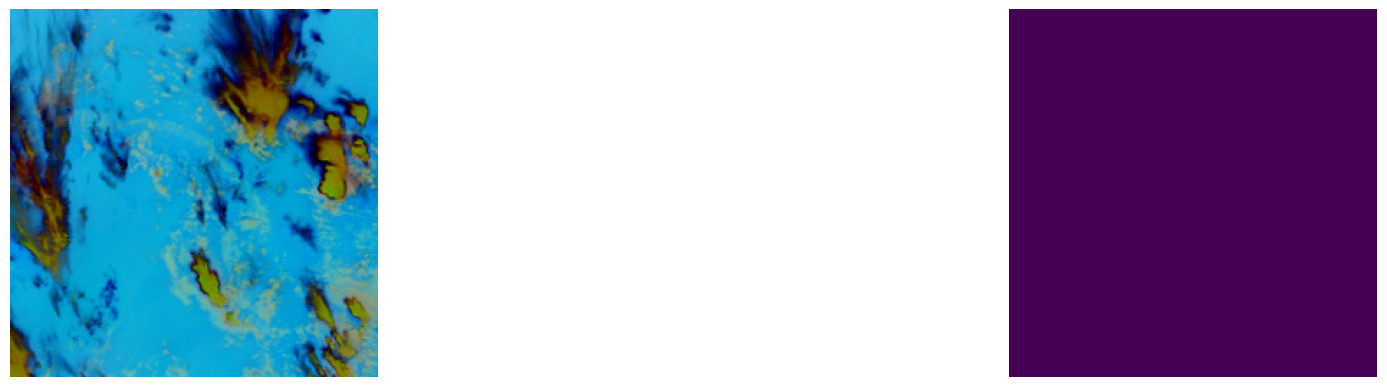

In [7]:
show_dataset(1300, dataset_valid)

# Model

In [8]:
num_gpus = torch.cuda.device_count()
device_ids = list(range(num_gpus))

model = build_model(CFG.model_arch, CFG.backbone, CFG.in_chans, CFG.target_size)
model = nn.DataParallel(model, device_ids=device_ids)
model.to(device);

model_arch:  Unet
backbone:  timm-resnest50d


In [9]:
scaler = amp.GradScaler()
criterion = smp.losses.DiceLoss(mode="multilabel", smooth=CFG.smooth)
optimizer = torch.optim.AdamW(model.parameters(), lr=CFG.lr)
scheduler = get_scheduler(CFG, optimizer)

thresholds_to_test = [round(x * 0.01, 2) for x in range(1, 101, 2)]

# Training

In [10]:
if CFG.debug:
    print("!!!Debug mode!!!\n")

dice_score=0
slacknotify=SlackNotify(CFG.exp_description)
for epoch in range(CFG.epochs):
    model.train()
    
    pbar_train = enumerate(dataloader_train)
    pbar_train = tqdm(pbar_train, total=len(dataloader_train), bar_format="{l_bar}{bar:10}{r_bar}{bar:-0b}")
    loss_train, loss_val= 0.0, 0.0
    for i, (images, masks) in pbar_train:
        images, masks = images.cuda(), masks.cuda()
        optimizer.zero_grad()
        with amp.autocast():
            preds = model(images)
            loss = criterion(preds, masks)
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            loss_train += loss.detach().item()
        
        lr = f"LR : {scheduler.get_lr()[0]:.2E}"
        gpu_mem = f"Mem : {torch.cuda.memory_reserved() / 1E9:.3g}GB"
        pbar_train.set_description(("%10s  " * 3 + "%10s") % (f"Epoch {epoch}/{CFG.epochs}", gpu_mem, lr,
                                                                f"Loss: {loss_train / (i + 1):.4f}"))

    scheduler.step()
    model.eval()
    
    cum_pred = []
    cum_true = []
    pbar_val = enumerate(dataloader_valid)
    pbar_val = tqdm(pbar_val, total=len(dataloader_valid), bar_format="{l_bar}{bar:10}{r_bar}{bar:-10b}")
    for i, (images, masks) in pbar_val:
        images, masks = images.cuda(), masks.cuda()
        with torch.no_grad():
            preds = model(images)[:,2]
            loss_val += criterion(preds, masks).item()
            preds = torch.sigmoid(preds)
            cum_pred.append(preds.cpu().detach().numpy())
            cum_true.append(masks.cpu().detach().numpy())

        pbar_val.set_description(("%10s") % (f"Val Loss: {loss_val / (i+1):.4f}"))
    
    cum_pred = torch.flatten(torch.from_numpy(np.concatenate(cum_pred, axis=0)))
    cum_true = torch.flatten(torch.from_numpy(np.concatenate(cum_true, axis=0)))
    
    dice_score_, thresh = calc_optim_thresh(cum_pred, cum_true, thresholds_to_test)
    
    if dice_score_ > dice_score:
        print(f"score : {dice_score_:.4f}\tthresh : {thresh}\tSAVED MODEL\n")
        slacknotify.send_reply(f"epoch : {epoch}\tscore : {dice_score_:.4f}\tBEST")
        epoch_best = epoch
        dice_score = dice_score_
        torch.save({'model': model.module.state_dict(), 'dice_score': dice_score, 'thresh': thresh,
                    "model_arch": CFG.model_arch, "backbone": CFG.backbone, "in_chans": CFG.in_chans, "target_size": CFG.target_size, },
                   f'./{CFG.exp_name}/{CFG.exp_name}.pth')
    else:
        print(f"score : {dice_score_:.4f}\tthresh : {thresh}\n")
        slacknotify.send_reply(f"epoch : {epoch}\tscore : {dice_score_:.4f}")

slacknotify.send_reply(f" {CFG.exp_description} training finished\tbest score : {dice_score}", True)


Epoch 0/40  Mem : 8.96GB  LR : 1.00E-04  Loss: 0.8598: 100%|██████████| 642/642 
Val Loss: 0.0770: 100%|██████████| 58/58 [00:15<00:00,  3.72it/s]               


score : 0.5355	thresh : 0.61	SAVED MODEL



Epoch 1/40  Mem : 8.96GB  LR : 1.00E-03  Loss: 0.5202: 100%|██████████| 642/642 
Val Loss: 0.0358: 100%|██████████| 58/58 [00:15<00:00,  3.69it/s]               


score : 0.5285	thresh : 0.01



Epoch 2/40  Mem : 8.96GB  LR : 1.00E-03  Loss: 0.4659: 100%|██████████| 642/642 
Val Loss: 0.0333: 100%|██████████| 58/58 [00:15<00:00,  3.73it/s]               


score : 0.5632	thresh : 0.01	SAVED MODEL



Epoch 3/40  Mem : 8.96GB  LR : 9.97E-04  Loss: 0.4485: 100%|██████████| 642/642 
Val Loss: 0.0339: 100%|██████████| 58/58 [00:13<00:00,  4.16it/s]               


score : 0.5670	thresh : 0.03	SAVED MODEL



Epoch 4/40  Mem : 8.96GB  LR : 9.89E-04  Loss: 0.4410: 100%|██████████| 642/642 
Val Loss: 0.0398: 100%|██████████| 58/58 [00:13<00:00,  4.27it/s]               


score : 0.5841	thresh : 0.99	SAVED MODEL



Epoch 5/40  Mem : 8.96GB  LR : 9.79E-04  Loss: 0.4345: 100%|██████████| 642/642 
Val Loss: 0.0345: 100%|██████████| 58/58 [00:13<00:00,  4.19it/s]               


score : 0.6044	thresh : 0.93	SAVED MODEL



Epoch 6/40  Mem : 8.96GB  LR : 9.65E-04  Loss: 0.4264: 100%|██████████| 642/642 
Val Loss: 0.0308: 100%|██████████| 58/58 [00:14<00:00,  4.11it/s]               


score : 0.6029	thresh : 0.01



Epoch 7/40  Mem : 8.96GB  LR : 9.49E-04  Loss: 0.4253: 100%|██████████| 642/642 
Val Loss: 0.0312: 100%|██████████| 58/58 [00:13<00:00,  4.26it/s]               


score : 0.6050	thresh : 0.01	SAVED MODEL



Epoch 8/40  Mem : 8.96GB  LR : 9.29E-04  Loss: 0.4186: 100%|██████████| 642/642 
Val Loss: 0.0390: 100%|██████████| 58/58 [00:13<00:00,  4.18it/s]               


score : 0.5959	thresh : 0.99



Epoch 9/40  Mem : 8.96GB  LR : 9.08E-04  Loss: 0.4139: 100%|██████████| 642/642 
Val Loss: 0.0329: 100%|██████████| 58/58 [00:13<00:00,  4.16it/s]               


score : 0.5951	thresh : 0.03



Epoch 10/40  Mem : 8.96GB  LR : 8.83E-04  Loss: 0.4103: 100%|██████████| 642/642
Val Loss: 0.0327: 100%|██████████| 58/58 [00:13<00:00,  4.24it/s]               


score : 0.6068	thresh : 0.63	SAVED MODEL



Epoch 11/40  Mem : 8.96GB  LR : 8.57E-04  Loss: 0.4102: 100%|██████████| 642/642
Val Loss: 0.0303: 100%|██████████| 58/58 [00:13<00:00,  4.21it/s]               


score : 0.5998	thresh : 0.01



Epoch 12/40  Mem : 8.96GB  LR : 8.28E-04  Loss: 0.4050: 100%|██████████| 642/642
Val Loss: 0.0318: 100%|██████████| 58/58 [00:13<00:00,  4.18it/s]               


score : 0.6154	thresh : 0.71	SAVED MODEL



Epoch 13/40  Mem : 8.96GB  LR : 7.97E-04  Loss: 0.4024: 100%|██████████| 642/642
Val Loss: 0.0322: 100%|██████████| 58/58 [00:13<00:00,  4.17it/s]               


score : 0.6113	thresh : 0.77



Epoch 14/40  Mem : 8.96GB  LR : 7.64E-04  Loss: 0.4002: 100%|██████████| 642/642
Val Loss: 0.0312: 100%|██████████| 58/58 [00:13<00:00,  4.24it/s]               


score : 0.6220	thresh : 0.51	SAVED MODEL



Epoch 15/40  Mem : 8.96GB  LR : 7.30E-04  Loss: 0.3977: 100%|██████████| 642/642
Val Loss: 0.0329: 100%|██████████| 58/58 [00:13<00:00,  4.23it/s]               


score : 0.6157	thresh : 0.97



Epoch 16/40  Mem : 8.96GB  LR : 6.94E-04  Loss: 0.3970: 100%|██████████| 642/642
Val Loss: 0.0312: 100%|██████████| 58/58 [00:13<00:00,  4.25it/s]               


score : 0.6236	thresh : 0.63	SAVED MODEL



Epoch 17/40  Mem : 8.96GB  LR : 6.57E-04  Loss: 0.3956: 100%|██████████| 642/642
Val Loss: 0.0358: 100%|██████████| 58/58 [00:13<00:00,  4.18it/s]               


score : 0.6173	thresh : 0.99



Epoch 18/40  Mem : 8.96GB  LR : 6.20E-04  Loss: 0.3910: 100%|██████████| 642/642
Val Loss: 0.0303: 100%|██████████| 58/58 [00:13<00:00,  4.27it/s]               


score : 0.6257	thresh : 0.01	SAVED MODEL



Epoch 19/40  Mem : 8.96GB  LR : 5.81E-04  Loss: 0.3879: 100%|██████████| 642/642
Val Loss: 0.0307: 100%|██████████| 58/58 [00:13<00:00,  4.25it/s]               


score : 0.6170	thresh : 0.01



Epoch 20/40  Mem : 8.96GB  LR : 5.42E-04  Loss: 0.3861: 100%|██████████| 642/642
Val Loss: 0.0301: 100%|██████████| 58/58 [00:13<00:00,  4.22it/s]               


score : 0.6330	thresh : 0.21	SAVED MODEL



Epoch 21/40  Mem : 8.96GB  LR : 5.03E-04  Loss: 0.3828: 100%|██████████| 642/642
Val Loss: 0.0318: 100%|██████████| 58/58 [00:14<00:00,  3.91it/s]               


score : 0.6315	thresh : 0.85



Epoch 22/40  Mem : 8.96GB  LR : 4.64E-04  Loss: 0.3823: 100%|██████████| 642/642
Val Loss: 0.0294: 100%|██████████| 58/58 [00:13<00:00,  4.28it/s]               


score : 0.6357	thresh : 0.01	SAVED MODEL



Epoch 23/40  Mem : 8.96GB  LR : 4.25E-04  Loss: 0.3823: 100%|██████████| 642/642
Val Loss: 0.0299: 100%|██████████| 58/58 [00:13<00:00,  4.30it/s]               


score : 0.6389	thresh : 0.49	SAVED MODEL



Epoch 24/40  Mem : 8.96GB  LR : 3.86E-04  Loss: 0.3774: 100%|██████████| 642/642
Val Loss: 0.0289: 100%|██████████| 58/58 [00:13<00:00,  4.27it/s]               


score : 0.6419	thresh : 0.07	SAVED MODEL



Epoch 25/40  Mem : 8.96GB  LR : 3.48E-04  Loss: 0.3751: 100%|██████████| 642/642
Val Loss: 0.0297: 100%|██████████| 58/58 [00:13<00:00,  4.24it/s]               


score : 0.6398	thresh : 0.07



Epoch 26/40  Mem : 8.96GB  LR : 3.11E-04  Loss: 0.3728: 100%|██████████| 642/642
Val Loss: 0.0285: 100%|██████████| 58/58 [00:13<00:00,  4.23it/s]               


score : 0.6428	thresh : 0.01	SAVED MODEL



Epoch 27/40  Mem : 8.96GB  LR : 2.76E-04  Loss: 0.3711: 100%|██████████| 642/642
Val Loss: 0.0296: 100%|██████████| 58/58 [00:13<00:00,  4.15it/s]               


score : 0.6396	thresh : 0.13



Epoch 28/40  Mem : 8.96GB  LR : 2.42E-04  Loss: 0.3688: 100%|██████████| 642/642
Val Loss: 0.0296: 100%|██████████| 58/58 [00:13<00:00,  4.20it/s]               


score : 0.6361	thresh : 0.13



Epoch 29/40  Mem : 8.96GB  LR : 2.09E-04  Loss: 0.3667: 100%|██████████| 642/642
Val Loss: 0.0293: 100%|██████████| 58/58 [00:13<00:00,  4.21it/s]               


score : 0.6442	thresh : 0.47	SAVED MODEL



Epoch 30/40  Mem : 8.96GB  LR : 1.78E-04  Loss: 0.3645: 100%|██████████| 642/642
Val Loss: 0.0290: 100%|██████████| 58/58 [00:13<00:00,  4.25it/s]               


score : 0.6423	thresh : 0.03



Epoch 31/40  Mem : 8.96GB  LR : 1.49E-04  Loss: 0.3638: 100%|██████████| 642/642
Val Loss: 0.0291: 100%|██████████| 58/58 [00:13<00:00,  4.18it/s]               


score : 0.6450	thresh : 0.15	SAVED MODEL



Epoch 32/40  Mem : 8.96GB  LR : 1.22E-04  Loss: 0.3638: 100%|██████████| 642/642
Val Loss: 0.0288: 100%|██████████| 58/58 [00:13<00:00,  4.26it/s]               


score : 0.6427	thresh : 0.03



Epoch 33/40  Mem : 8.96GB  LR : 9.81E-05  Loss: 0.3613: 100%|██████████| 642/642
Val Loss: 0.0290: 100%|██████████| 58/58 [00:13<00:00,  4.23it/s]               


score : 0.6459	thresh : 0.05	SAVED MODEL



Epoch 34/40  Mem : 8.96GB  LR : 7.62E-05  Loss: 0.3597: 100%|██████████| 642/642
Val Loss: 0.0288: 100%|██████████| 58/58 [00:13<00:00,  4.15it/s]               


score : 0.6479	thresh : 0.39	SAVED MODEL



Epoch 35/40  Mem : 8.96GB  LR : 5.69E-05  Loss: 0.3585: 100%|██████████| 642/642
Val Loss: 0.0288: 100%|██████████| 58/58 [00:13<00:00,  4.30it/s]               


score : 0.6492	thresh : 0.37	SAVED MODEL



Epoch 36/40  Mem : 8.96GB  LR : 4.04E-05  Loss: 0.3583: 100%|██████████| 642/642
Val Loss: 0.0288: 100%|██████████| 58/58 [00:13<00:00,  4.25it/s]               


score : 0.6486	thresh : 0.13



Epoch 37/40  Mem : 8.96GB  LR : 2.67E-05  Loss: 0.3566: 100%|██████████| 642/642
Val Loss: 0.0288: 100%|██████████| 58/58 [00:13<00:00,  4.29it/s]               


score : 0.6489	thresh : 0.05



Epoch 38/40  Mem : 8.96GB  LR : 1.58E-05  Loss: 0.3570: 100%|██████████| 642/642
Val Loss: 0.0286: 100%|██████████| 58/58 [00:13<00:00,  4.30it/s]               


score : 0.6496	thresh : 0.11	SAVED MODEL



Epoch 39/40  Mem : 8.96GB  LR : 7.90E-06  Loss: 0.3559: 100%|██████████| 642/642
Val Loss: 0.0286: 100%|██████████| 58/58 [00:13<00:00,  4.24it/s]               


score : 0.6493	thresh : 0.03



In [11]:
pth = torch.load(f'./{CFG.exp_name}/{CFG.exp_name}.pth')

model = build_model(pth["model_arch"], pth["backbone"], pth["in_chans"], pth["target_size"], weight=None)
model.load_state_dict(pth['model'])
thresh = pth['thresh']
dice_score = pth['dice_score']
print(f"{dice_score:.4f}")

model.to(device)
model.eval();


model_arch:  Unet
backbone:  timm-resnest50d
0.6496


In [12]:
# for i, (images, masks) in enumerate(dataloader_valid):
#     if i!=1: continue
    
#     images, masks = images.cuda(), masks.cuda()
#     with torch.no_grad():
#         preds = model(images)
#         preds = torch.sigmoid(preds)[:,2]
#     images, masks, preds = images.cpu(), masks.cpu(), preds.cpu()
#     preds=torch.unsqueeze(preds, axis=1)
#     print(preds.shape)
    
#     for num in range(CFG.valid_batch_size):
#         fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(20,5))
#         axes = axes.flatten()
#         axes[0].imshow(images[num].permute(1,2,0))
#         axes[0].axis('off')
#         axes[0].set_title('Image')
#         axes[1].imshow(masks[num].permute(1,2,0)[:,:,2])
#         axes[1].axis('off')
#         axes[1].set_title('Ground Truth')
#         axes[2].imshow(preds[num].permute(1,2,0))
#         axes[2].axis('off')
#         axes[2].set_title('pred')
#         axes[3].imshow((preds[num]>thresh).permute(1,2,0))
#         axes[3].axis('off')
#         axes[3].set_title('pred_thresh')
#     break